# Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')

In [3]:
df = df[['neighbourhood_group', 'room_type', 'latitude', 'longitude', 'price', 'minimum_nights',
         'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
df.head(3)

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,40.64749,-73.97237,149,1,9,0.21,6,365
1,Manhattan,Entire home/apt,40.75362,-73.98377,225,1,45,0.38,2,355
2,Manhattan,Private room,40.80902,-73.94190,150,3,0,NaN,1,365


In [4]:
df.shape

(48895, 10)

In [5]:
df['reviews_per_month'].fillna(0.0, inplace=True)

### Question 1

What is the most frequent observation (mode) for the column 'neighbourhood_group'?

In [6]:
df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

### Train-Test-Split

In [7]:
X = df[['neighbourhood_group', 'room_type', 'latitude', 'longitude', 'minimum_nights',
         'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
y = df['price']

In [8]:
Xtv, Xtest, ytv, ytest = train_test_split(X, y, random_state=42, test_size=0.2)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.25)

In [9]:
Xtrain.shape, Xval.shape, Xtest.shape

((29337, 9), (9779, 9), (9779, 9))

In [10]:
ytrain.shape, yval.shape, ytest.shape

((29337,), (9779,), (9779,))

### Some EDA

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

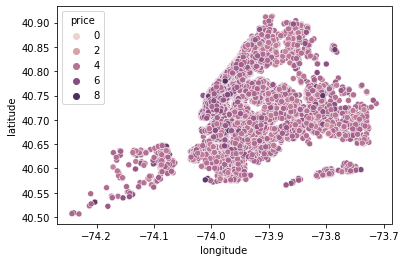

In [24]:
sns.scatterplot(data=Xtrain, hue=np.log1p(ytrain), x='longitude', y='latitude')

### Question 2
Create the correlation matrix for the numerical features of your train dataset.
In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

In [11]:
corrdata = Xtrain.copy()
corrdata['log_price'] = np.log1p(ytrain)

In [12]:
cm = corrdata.corr()
cm.round(3)

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
latitude,1.000,0.083,0.023,-0.007,-0.009,0.022,-0.007,0.083
longitude,0.083,1.000,-0.061,0.054,0.134,-0.112,0.083,-0.324
minimum_nights,0.023,-0.061,1.000,-0.075,-0.116,0.120,0.137,0.032
number_of_reviews,-0.007,0.054,-0.075,1.000,0.580,-0.073,0.178,-0.040
reviews_per_month,-0.009,0.134,-0.116,0.580,1.000,-0.049,0.167,-0.060
calculated_host_listings_count,0.022,-0.112,0.120,-0.073,-0.049,1.000,0.223,0.131
availability_365,-0.007,0.083,0.137,0.178,0.167,0.223,1.000,0.097
log_price,0.083,-0.324,0.032,-0.040,-0.060,0.131,0.097,1.000


<AxesSubplot:>

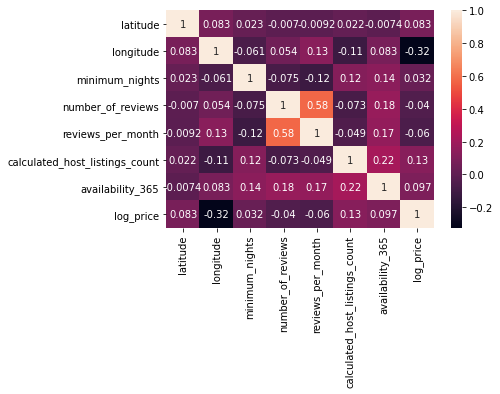

In [13]:
sns.heatmap(cm, annot=True)

### Make price binary

We need to turn the price variable from numeric into binary.
Let's create a variable above_average which is 1 if the price is above (or equal to) 152.

In [14]:
above_avg_train = (ytrain >= 152).astype(int)
above_avg_val = (yval >= 152).astype(int)
above_avg_test = (ytest >= 152).astype(int)

### Question 3

Calculate the mutual information score with the (binarized) price for the two categorical variables that we have. Use the training set only.
Which of these two variables has bigger score?
Round it to 2 decimal digits using round(score, 2)

#### Entropy

I calculate the entropy because $H(X)$ should be identical to $I(X, X)$.

$H = -\sum p * log p$

In [74]:
p = above_avg_train.value_counts() / len(above_avg_train)
p

0    0.693936
1    0.306064
Name: price, dtype: float64

In [77]:
# using the natural logs throughout for consistency
# not the binary log often found
from math import log

H = -(p[0] * log(p[0]) + p[1] * log(p[1]))
round(H, 4)  # measured in bits

0.6159

#### Mutual Information

Implement the mutual information from scratch to compare it to the scikit function. I want to make sure I understand the thing.

$I(X, Y) = \sum_x \sum_y p(x,y) * log(\dfrac{p(x,y)}{p(x)*p(y)})$

In [78]:
# somewhat messy implementation
# code would require testing

data = Xtrain[['neighbourhood_group']].copy()
data['y'] = above_avg_train
data['x'] = data['neighbourhood_group']
del data['neighbourhood_group']
data['dummy'] = 1
data.head(3)

,y,x,dummy
46204,0,Manhattan,1
19355,1,Manhattan,1
4350,0,Manhattan,1


In [79]:
p = data.groupby(['x', 'y']).count() / len(data)
p

dummy
x             y          
Bronx         0  0.021406
              1  0.001773
Brooklyn      0  0.325493
              1  0.088284
Manhattan     0  0.238572
              1  0.201043
Queens        0  0.101817
              1  0.013907
Staten Island 0  0.006647
              1  0.001057

$I(X, Y) = \sum_x \sum_y p(x,y) * log(\dfrac{p(x,y)}{p(x)*p(y)})$

In [80]:
info = 0.0

for (x, y), prob in p.iterrows():
    p_xy = prob.values[0]
    p_x = p.loc[x].values.sum()
    p_y = p.unstack()['dummy'][y].sum()
    info += p_xy * log( p_xy / (p_x * p_y))
    
round(info, 5)

0.04647

#### Calculation with scikit

In [67]:
from sklearn.metrics import mutual_info_score

In [85]:
round(mutual_info_score(above_avg_train, Xtrain['neighbourhood_group']), 2)

0.05

In [84]:
round(mutual_info_score(above_avg_train, Xtrain['room_type']), 2)

0.14

In [81]:
# variable with itself should be same as H
round(mutual_info_score(above_avg_train, above_avg_train), 4)

0.6159

In [82]:
# variable with random data should be close to zero
round(mutual_info_score(above_avg_train, np.random.randint(1,6,size=above_avg_train.shape)), 2)

0.0

### Question 4

Now let's train a logistic regression

Remember that we have two categorical variables in the data. Include them using one-hot encoding.
Fit the model on the training dataset.

In [44]:
Xtrain.head(3)

,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
846,Brooklyn,Private room,40.69309,-73.97074,3,1,0.07,1,0
21599,Brooklyn,Entire home/apt,40.65258,-73.96240,1,0,0.00,1,0
2695,Manhattan,Entire home/apt,40.72620,-73.97913,10,2,0.03,1,234


In [79]:
pipe = make_pipeline(
    ColumnTransformer([
        ('onehot', OneHotEncoder(drop='first', handle_unknown='error'), ['neighbourhood_group', 'room_type']),
    ], remainder='passthrough'),
    MinMaxScaler(),
    LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
)

In [81]:
pipe.fit(Xtrain, above_avg_train)
round(pipe.score(Xtrain, above_avg_train), 2)

/home/kristian/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8

Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [82]:
round(pipe.score(Xval, above_avg_val), 2)

0.8

In [83]:
pipe.named_steps['logisticregression'].coef_

array([[ 0.0132074 ,  0.99666498,  0.40975317, -2.97222753, -2.72773842,
        -2.98360423, -1.02854426, -6.68225235, -5.71097859, -1.88508873,
        -0.88337994,  1.00924825,  1.06638452]])

### Question 5

We have 9 features: 7 numerical features and 2 categorical.

Let's find the least useful one using the feature elimination technique.

Train a model with all these features (using the same parameters as in Q4).

In [74]:
acc_orig_train = pipe.score(Xtrain, above_avg_train)
acc_orig_val = pipe.score(Xval, above_avg_val)

Now exclude each feature from this set and train a model without it. Record the accuracy for each model.

For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
Which of following feature has the smallest difference?

note: the difference doesn't have to be positive

In [113]:
def train_diff(onehot_cols, pass_cols):
    pipe = make_pipeline(
        ColumnTransformer([
            ('onehot', OneHotEncoder(drop='first', handle_unknown='error'), onehot_cols),
            ('pass', 'passthrough', pass_cols)
        ]),
        MinMaxScaler(),
        LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
    )
    pipe.fit(Xtrain, above_avg_train)
    acc_train = pipe.score(Xtrain, above_avg_train)
    acc_val = pipe.score(Xval, above_avg_val)
    dtrain = round(acc_orig_train - acc_train, 4)
    dval = round(acc_orig_val - acc_val, 4)
    return dtrain, dval

In [114]:
# A) eliminate neighbourhood_group
train_diff(['room_type'], 
      ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
       'reviews_per_month', 'calculated_host_listings_count', 'availability_365'])

(0.0017, 0.0056)

In [115]:
# B) eliminate room_type
train_diff(['neighbourhood_group'], 
      ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
       'reviews_per_month', 'calculated_host_listings_count', 'availability_365'])

(0.0577, 0.0555)

In [116]:
# C) eliminate n_reviews
train_diff(['room_type', 'neighbourhood_group'], 
      ['latitude', 'longitude', 'minimum_nights', 
       'reviews_per_month', 'calculated_host_listings_count', 'availability_365'])

(0.0009, -0.0001)

In [119]:
# D) eliminate reviews per month - BEST
train_diff(['room_type', 'neighbourhood_group'], 
      ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365'])

(-0.0, -0.0002)

### Question 6

For this question, we'll see how to use a linear regression model from Scikit-Learn

We'll need to use the original column 'price'. Apply the logarithmic transformation to this column.

Fit the Ridge regression model on the training data.

This model has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10]
Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest alpha.

In [92]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [90]:
ytrain_log = np.log1p(ytrain)
yval_log = np.log1p(yval)

In [97]:
pipe = make_pipeline(
    ColumnTransformer([
        ('onehot', OneHotEncoder(drop='first', handle_unknown='error'), ['neighbourhood_group', 'room_type']),
    ], remainder='passthrough'),
    MinMaxScaler(),
    Ridge()
)

In [98]:
params = {'ridge__alpha': [0.0, 0.01, 0.1, 1.0, 10.0]}

g = GridSearchCV(
    pipe,
    params
)

In [99]:
g.fit(Xtrain, ytrain_log)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['neighbourhood_group',
                                                                          'room_type'])])),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.0, 0.01, 0.1, 1.0, 10.0]})

In [100]:
g.best_params_

{'ridge__alpha': 1.0}

In [104]:
# these are R^2 scores, not RMSEs
g.cv_results_['mean_test_score'].round(3)

array([0.483, 0.483, 0.483, 0.483, 0.482])

#### Repeat manually
GridSearchCV does an additional split.

In [110]:
from sklearn.metrics import mean_squared_error

for alpha in [0.0, 0.01, 0.1, 1.0, 10.0, 10000.0]:
    pipe = make_pipeline(
    ColumnTransformer([
        ('onehot', OneHotEncoder(drop='first', handle_unknown='error'), ['neighbourhood_group', 'room_type']),
    ], remainder='passthrough'),
    MinMaxScaler(),
    Ridge(alpha=alpha)
    )
    pipe.fit(Xtrain, ytrain_log)
    ytrain_pred = pipe.predict(Xtrain)
    yval_pred = pipe.predict(Xval)
    
    train_mse = mean_squared_error(ytrain_log, ytrain_pred)
    val_mse = mean_squared_error(yval_log, yval_pred)
    print(f"{alpha:8.2f}    MSE train: {train_mse:8.3f}    MSE val: {val_mse:8.3f}")

    0.00    MSE train:    0.252    MSE val:    0.245
    0.01    MSE train:    0.252    MSE val:    0.245
    0.10    MSE train:    0.252    MSE val:    0.245
    1.00    MSE train:    0.252    MSE val:    0.245
   10.00    MSE train:    0.253    MSE val:    0.246
10000.00    MSE train:    0.346    MSE val:    0.336


In [111]:
Xtrain

,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
46204,Manhattan,Private room,40.72612,-73.98946,3,0,0.00,3,12
19355,Manhattan,Entire home/apt,40.74068,-74.00295,2,134,4.17,1,70
4350,Manhattan,Private room,40.75293,-73.97173,14,9,0.14,1,21
1894,Manhattan,Entire home/apt,40.73126,-74.00502,7,7,0.10,1,365
47442,Bronx,Private room,40.88587,-73.89865,4,0,0.00,1,87
...,...,...,...,...,...,...,...,...,...
17559,Brooklyn,Entire home/apt,40.65192,-73.95243,7,1,0.03,1,0
44102,Manhattan,Entire home/apt,40.80665,-73.96062,31,0,0.00,1,57
39519,Manhattan,Private room,40.83024,-73.94715,1,1,0.25,6,40
19050,Manhattan,Entire home/apt,40.74438,-73.97365,1,1,0.03,1,0
